# Complexity measure as peaks

In [14]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids


kr = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)


viat = enzyme_set(
    [
        enzyme({"V": 0.35, "I": 0.25, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)
protein = "MKAAVLTLAVLFLTGSQARHFWQQDEPPQSPWDRVKDLATVYVDVLKDSGRDYVSQFEGSALGKQLNLKLLDNWDSVTSTFSKLREQLGPVTQEFWDNLEKETEGLRQEMSKDLEEVKAKVQPYLDDFQKKWQEEMELYRQKVEPLRAELQEGARQKLHELQEKLSPLGEEMRDRARAHVDALRTHLAPYSDELRQRLAARLEALKENGGARLAEYHAKATEHLSTLSEKAKPALEDLRQGLLPVLESFKVSFLSALEEYTKKLNTQ"

In [15]:
from disassembly.benchmark import Benchmark

n_iterations = 5
bmrk = Benchmark()

enzyme_sets = [kr, viat, random]
enzyme_names = ["K", "V+I+A+T", "random"]

bmrk.simulate_degradation(
    protein,
    enzyme_sets=enzyme_sets,
    enzyme_names=enzyme_names,
    n_generate=100,
    endo_or_exo_probability=[0.9, 0.1],
    iterations=n_iterations,
)

Running K, 0
 0 / 100 (1)

 44 / 100 (53)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:227: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


 99 / 100 (122)
56 unique peptides. 103 total

 Averaged DI: 1.46
Running K, 1
 99 / 100 (107)
62 unique peptides. 104 total

 Averaged DI: 1.48
Running K, 2
 99 / 100 (113)
49 unique peptides. 103 total

 Averaged DI: 1.47
Running K, 3
 99 / 100 (115)
61 unique peptides. 103 total

 Averaged DI: 1.50
Running K, 4
 99 / 100 (126)
55 unique peptides. 103 total

 Averaged DI: 1.58
Running V+I+A+T, 0
 99 / 100 (113)
73 unique peptides. 103 total

 Averaged DI: 1.54
Running V+I+A+T, 1
 99 / 100 (113)
78 unique peptides. 103 total

 Averaged DI: 1.57
Running V+I+A+T, 2
 99 / 100 (113)
74 unique peptides. 103 total

 Averaged DI: 1.49
Running V+I+A+T, 3
 99 / 100 (113)
80 unique peptides. 103 total

 Averaged DI: 1.48
Running V+I+A+T, 4
 99 / 100 (111)
84 unique peptides. 103 total

 Averaged DI: 1.39
Running random, 0
 99 / 100 (109)
101 unique peptides. 103 total

 Averaged DI: 1.73
Running random, 1
 99 / 100 (105)
101 unique peptides. 103 total

 Averaged DI: 1.66
Running random, 2
 99 /

In [16]:
import numpy as np
from disassembly.util import KL

dct = {"e": [], "i": [], "error": [], "kl": [], "d": []}
for enzyme_name in bmrk.enzyme_names:

    for iteration in range(bmrk.iterations):

        spaces = np.zeros(len(protein))

        for sequence, copy_number in bmrk.simulated_peptidomes[enzyme_name][
            iteration
        ].items():
            start = protein.find(sequence)
            end = start + len(sequence)
            spaces[start:end] += copy_number

        mean = np.mean(spaces)
        error = np.sum(np.abs(spaces - mean) ** 2)
        kl = KL(np.ones(len(protein)) * mean, spaces)
        dct["e"].append(enzyme_name)
        dct["i"].append(iteration)
        dct["error"].append(error)
        dct["kl"].append(kl)
        dct["d"].append(bmrk.results["real"][enzyme_name][iteration]["d"])

<Axes: xlabel='kl', ylabel='Density'>

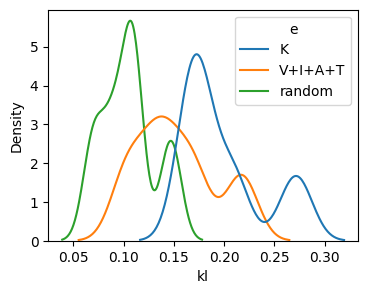

In [17]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

dct_df = pd.DataFrame(dct)
plt.figure(figsize=(4, 3))
sns.kdeplot(dct_df, x="kl", hue="e", bw_adjust=0.5)

<Axes: xlabel='d', ylabel='Density'>

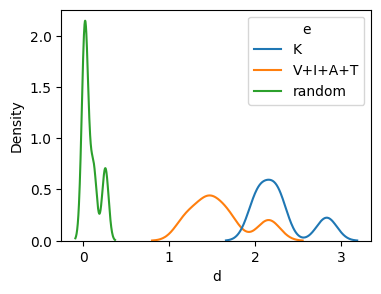

In [18]:
plt.figure(figsize=(4, 3))
sns.kdeplot(dct_df, x="d", hue="e", bw_adjust=0.5)

Text(0.5, 1.0, 'n_generate=1000')

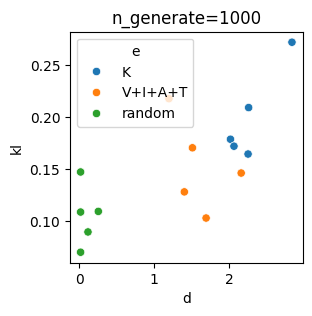

In [19]:
plt.figure(figsize=(3, 3))
sns.scatterplot(dct_df, x="d", y="kl", hue="e")
plt.title("n_generate=1000")

# Regex enzyme

In [1]:
from disassembly.simulate_proteolysis_regex import ProteolysisSimulator, Enzyme

ps = ProteolysisSimulator()
hbb = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
thrb = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"
actb = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF"
chymotrp_regex = Enzyme("chymotrypsin", [("(.)(.)([F|Y|W|M])([^P])(.)(.)(.)", 1)])
protein_sequences = []
true_distributions = []
for seq in [actb, hbb, pr39, thrb]:
    true_distribution = ps.simulate_proteolysis(
        seq, enzyme=chymotrp_regex, n_generate=500, graph=False
    )
    protein_sequences.append(seq)
    true_distributions.append(true_distribution)
protein_sequences

 499 / 500 (593)
134 unique peptides. 510 total
 499 / 500 (575)
107 unique peptides. 510 total
 499 / 500 (637)
86 unique peptides. 510 total
 499 / 500 (630)
127 unique peptides. 510 total


['MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF',
 'MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH',
 'METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR',
 'MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNY

# Genetic algorithm to get cleavage spec

In [37]:
from disassembly.simulate_proteolysis_regex import Enzyme
from disassembly.util import amino_acids, normalize_dict, KL
import random
import math
import pandas as pd
import numpy as np
import re
import logomaker

amino_acids = list(amino_acids.values())


class Individual:
    """
    Class that represents an individual
    Has checks to assure that the regex doesn't break any rules.
    """

    id: int = 0

    def __init__(self, rules: list = None) -> None:
        """
        rules is a list of tuples with (regex, amount)
        """
        self.rules = rules
        Individual.id += 1
        self.id = Individual.id

    def get_length_of_match(self):
        return len(self.split()[0][0])

    def split(self):
        list_of_components = []
        for rule, amount in self.rules:
            components = []
            for i, char in enumerate(rule):
                if char == "(":
                    k = i
                if char == ")":
                    components.append(rule[k + 1 : i])
            list_of_components.append((components, amount))
        return list_of_components

    def compile(self, list_of_operators):
        rule = ""
        for operator in list_of_operators:
            rule += f"({operator})"
        try:
            re.compile(rule)
        except re.error:
            print(rule, " is not a valid regex pattern")
        return rule

    def simplify(self):
        all_rules = {rule: amount for rule, amount in self.rules}
        simplified_rules = {}
        for rule, amount in all_rules.items():
            if rule in simplified_rules.keys():
                simplified_rules[rule] += amount
            else:
                simplified_rules[rule] = amount
        self.rules = [(rule, amount) for rule, amount in simplified_rules.items()]

    def mutate_rule(self, mutation_rate: float):
        """
        Picks a random regex-rule and mutates it by either removing or adding a rule
        """
        for rule_index in range(len(self.rules)):
            for position in range(self.get_length_of_match()):
                u = random.random()
                if u <= mutation_rate:
                    add_or_delete = random.choice(["add", "delete"])
                    type = random.choice(["inclusion", "exclusion"])
                    list_of_operators, amount = self.split()[rule_index]
                    operator: str = list_of_operators[position]

                    if add_or_delete == "add":

                        aa = random.choice(amino_acids)

                        if aa in operator:
                            continue

                        if type == "inclusion":

                            if operator == ".":
                                new_operator = f"[{aa}]"
                            else:
                                if "^" in operator:
                                    new_operator = (
                                        "["
                                        + operator.removeprefix("[^").removesuffix("]")
                                        + f"|{aa}]"
                                    )
                                else:
                                    new_operator = (
                                        "["
                                        + operator.removeprefix("[").removesuffix("]")
                                        + f"|{aa}]"
                                    )

                        elif type == "exclusion":

                            if operator == ".":
                                new_operator = f"[^{aa}]"
                            else:
                                if "^" in operator:
                                    new_operator = (
                                        "["
                                        + operator.removeprefix("[").removesuffix("]")
                                        + f"|{aa}]"
                                    )
                                else:
                                    new_operator = (
                                        "[^"
                                        + operator.removeprefix("[").removesuffix("]")
                                        + f"|{aa}]"
                                    )

                    elif add_or_delete == "delete":
                        if operator == ".":

                            new_rule = self.compile(list_of_operators)
                            self.rules[rule_index] = (new_rule, amount)
                            return

                        ops = operator.split("|")
                        if len(ops) == 1:
                            new_operator = "."
                        else:
                            n_ops = len(ops)
                            i_del = random.randint(0, n_ops - 1)
                            ops.remove(ops[i_del])
                            new_operator = "|".join(ops)
                            new_operator = (
                                "["
                                + new_operator.removeprefix("[").removesuffix("]")
                                + "]"
                            )

                    list_of_operators[position] = new_operator
                    new_rule = self.compile(list_of_operators)
                    self.rules[rule_index] = (new_rule, amount)

    def mutate_amount(self, mutation_rate: float):
        """
        Mutates the amount by either adding or substracting
        """
        for rule in self.rules:
            u = random.random()
            if u <= mutation_rate:
                regex, amount = rule
                self.rules.remove(rule)
                add_or_sub = random.choice(["add", "sub"])
                if add_or_sub == "add":
                    amount += 1
                else:
                    amount -= 1
                if amount > 0:
                    self.rules.append((regex, amount))
                elif len(self.rules) == 0:
                    self.rules.append(("(.)(.)(.)(.)(.)(.)", 1))

    def mutate_rule_drop(self, mutation_rate: float):
        for rule in self.rules:
            u = random.random()
            if u <= mutation_rate:
                self.rules.remove(rule)
                if len(self.rules) == 0:
                    self.rules.append(("(.)(.)(.)(.)(.)(.)", 1))
                    break

    def __repr__(self) -> str:
        s = str(self.id) + ":"
        for rule, amount in self.rules:
            s += rule + " " + str(amount) + " "
        return s


class ParameterEstimatorGA:
    def __init__(
        self,
        true_distributions: list,
        protein_sequences: list,
        mutation_rate: float = 0.1,
        n_individuals: int = 10,
        pattern_len: int = 6,
        kill_fraction: float = 0.5,
        n_generate: int = 200,
        length_penalty: float = 0.1,
    ) -> None:
        """
        Initiate a random population
        """
        if isinstance(true_distributions, dict):
            self.true_distributions = [normalize_dict(true_distributions)]
        else:
            self.true_distributions = [
                normalize_dict(true_distribution)
                for true_distribution in true_distributions
            ]

        if isinstance(protein_sequences, str):
            self.protein_sequences = [protein_sequences]
        else:
            self.protein_sequences = protein_sequences

        self.mutation_rate = mutation_rate
        self.n_individuals = n_individuals
        self.pattern_len = pattern_len
        self.n_generate = n_generate
        self.n_kill = math.floor(kill_fraction * n_individuals)

        self.length_penalty = length_penalty
        self.ps = ProteolysisSimulator(verbose=False)

        self.init_pop()
        self._get_baseline_fitness()
        self.evaluate_fitness(0)

    def init_pop(self):
        """
        Initializes the population
        """
        self.population = {}  # dict of Enzyme:fitness
        for n_ind in range(self.n_individuals):
            ind_regex = self._initialize_aminoacids(
                n_ind
            )  # self._generate_random_regex()
            individual = Individual([(ind_regex, 1)])
            self.population[individual] = 0  # fitness init as 0

    def run(self, n_generations: int = 10):
        """
        Main run-method
        """
        self.all_results = {}
        self.best_ever = None
        self.best_ever_fitness = 10e3
        self.fitness = {}

        self.fitness[-1] = list(self.population.values()).append(0)
        self.fitness[-1]

        for generation in range(n_generations):
            self.kill_reproduce()
            self.mutate()
            self.simplify_individuals()
            self.evaluate_fitness(generation)

            for individual, fitness in self.population.items():
                self.all_results[individual] = fitness

            best_individual = list(self.population.keys())[0]
            best_fitness = self.population[best_individual]

            if best_fitness < self.best_ever_fitness:
                self.best_ever = best_individual
                self.best_ever_fitness = best_fitness

            print(best_individual, best_fitness)

            self.fitness[generation] = list(self.population.values())
            print(len(self.population))

    def simplify_individuals(self):
        for individual in self.population.keys():
            individual: Individual
            individual.simplify()

    def evaluate_fitness(self, generation: int):
        """
        Evaluate fitness of individuals:

        - simulate proteolysis with given rules (individuals)
        - Compute similarity to true distribution
        """
        n_protein_sequences = len(self.protein_sequences)
        protein_sequence = self.protein_sequences[generation % n_protein_sequences]
        true_distribution = self.true_distributions[generation % n_protein_sequences]
        for individual in self.population.keys():
            e = Enzyme(name="_", cleavage_rules=individual.rules)
            t_hat = self.ps.simulate_proteolysis(
                protein_sequence,
                enzyme=e,
                n_generate=self.n_generate,
                graph=False,
                length_params="vitro",
            )
            t_hat = normalize_dict(t_hat)
            t1, t2 = self._make_comparable(t_hat, true_distribution)
            loss = self._get_loss(individual, t1, t2) / self.baseline_fitness[protein_sequence]
            self.population[individual] = loss

        self.population = {
            k: v for k, v in sorted(self.population.items(), key=lambda item: item[1])
        }

    def kill_reproduce(self):
        """
        Combine kill and reroduce into one method
        """
        keys = list(self.population.keys())
        not_kill = keys[: self.n_individuals - self.n_kill]
        kill = keys[self.n_individuals - self.n_kill :]

        for key in kill:
            self.population.pop(key)  # kill individual

        while len(self.population) < self.n_individuals:
            parents = random.choices(not_kill, k=2)
            offspring = self.mate(parents[0], parents[1])  # reproduce
            self.population[offspring] = 0

    def mate(self, ind1: Individual, ind2: Individual):
        """
        Pair 2 individuals to create a new
        """
        offspring_rules = ind1.rules + ind2.rules
        offspring = Individual(offspring_rules)
        return offspring

    def mutate(self):
        """
        Mutates individuals randomly
        """
        keys = list(self.population.keys())

        best_individual = Individual(rules=keys[0].rules)

        for individual in keys:
            individual: Individual
            self.population.pop(individual)
            individual.mutate_rule(self.mutation_rate)
            self.population[individual] = 0

        keys = list(self.population.keys())
        for individual in keys:
            self.population.pop(individual)
            individual.mutate_amount(self.mutation_rate)
            self.population[individual] = 0

        keys = list(self.population.keys())
        for individual in keys:
            self.population.pop(individual)
            individual.mutate_rule_drop(self.mutation_rate)
            self.population[individual] = 0

        self.population[best_individual] = 0

    def _initialize_aminoacids(self, i: int):
        n_amino_acids = len(amino_acids)
        i = i % n_amino_acids
        aa = amino_acids[i]
        return f"(.)(.)([{aa}])(.)(.)(.)"

    def _make_comparable(self, t1: dict, t2: dict):
        """
        Aligns two dicts and outputs the aligned value-vectors
        """
        t1_vec = []
        t2_vec = []
        for key in t1.keys():
            t1_vec.append(t1[key])
            if key in t2.keys():
                t2_vec.append(t2[key])
            else:
                t2_vec.append(0)
        for key in t2.keys():
            if key not in t1.keys():
                t1_vec.append(0)
                t2_vec.append(t2[key])
        return t1_vec, t2_vec

    def _get_baseline_fitness(self):
        self.baseline_fitness = {}
        naive_enzyme = Enzyme("naive", [("(.)(.)(.)(.)(.)(.)", 1)])
        for protein_sequence, true_distribution in zip(protein_sequences, true_distributions):
            t_hat = self.ps.simulate_proteolysis(
                protein_sequence,
                enzyme=naive_enzyme,
                n_generate=self.n_generate,
                graph=False,
                length_params="vitro",
            )
            t_hat = normalize_dict(t_hat)
            t1, t2 = self._make_comparable(t_hat, true_distribution)
            loss = KL(t1, t2) + KL(t2, t1)
            self.baseline_fitness[protein_sequence] = loss

    def _get_loss(self, individual: Individual, t1: dict, t2: dict):
        penalty = self.length_penalty * sum(
            [len(re.findall("[A-Z]", rule)) for rule, _ in individual.rules]
        )
        loss = KL(t1, t2) + KL(t2, t1)
        loss += penalty
        return loss

    def plot(self, topn: int = 10):
        d = {}
        top_population = {
            k: v
            for k, v in sorted(self.all_results.items(), key=lambda item: item[1])[
                0:topn
            ]
        }
        for pos in range(self.pattern_len):
            d[pos] = {}
            for aa in amino_acids:
                d[pos][aa] = 0

        max_fitness = max(top_population.values())
        for seqs, fitness in top_population.items():
            seqs = seqs.split()

            for seq, amount in seqs:
                for pos in range(len(seq)):
                    if seq[pos].startswith("[^"):
                        s = seq[pos].removeprefix("[^").removesuffix("]")
                        s = s.split("|")
                        for aa in s:
                            d[pos][aa] -= amount * abs(fitness - max_fitness)
                    elif seq[pos].startswith("["):
                        s = seq[pos].removeprefix("[").removesuffix("]")
                        s = s.split("|")
                        for aa in s:
                            d[pos][aa] += amount * abs(fitness - max_fitness)
        df = pd.DataFrame(d).T
        df = df.apply(abs)
        row_sums = df.sum(axis=1) + 1e-5
        df = df.div(row_sums, axis=0)
        ginis = []
        for _, row in df.iterrows():
            gini = np.sum(row**2)
            ginis.append(gini)
        df = pd.DataFrame(d).T.mul(ginis, axis=0)
        logomaker.Logo(df, fade_below=0.75)


pega = ParameterEstimatorGA(
    true_distributions,
    protein_sequences,
    n_individuals=20,
    mutation_rate=0.05,
    kill_fraction=0.5,
    n_generate=50,
    length_penalty=0.1,
)

pega.run(n_generations=10)

21:(.)(.)([Y])(.)(.)(.) 1  0.7586753356492089
21
26:(.)(.)([F])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1  0.5129067116369774
21
45:(.)(.)([Y])(.)(.)(.) 1 (.)(.)([M])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 2  0.4521711258142797
21
57:(.)(.)([W])(.)(.)(.) 1 (.)(.)([Y])(.)(.)(.) 1 (.)(.)([M])(.)(.)(.) 1 (.)(.)([F])(.)(.)(.) 1  0.6336110617984069
21
50:(.)(.)([Y])(.)(.)(.) 1 (.)(.)([M])(.)(.)(.) 1  0.5599641068134016
21
79:(.)(.)([W])(.)(.)([^V]) 1 (.)(.)([Y])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1 (.)(.)([M])(.)(.)(.) 1 (.)(.)([F])(.)(.)(.) 1  0.3387796892610026
21
90:(.)([H])([S])(.)(.)(.) 1 (.)(.)([W])(.)(.)(.) 1 (.)(.)([Y])(.)(.)(.) 2 (.)(.)([M])(.)(.)(.) 1 (.)(.)([F])(.)(.)(.) 1 (.)(.)([Y])([^V])(.)(.) 1  0.3896643741978864
21
78:(.)([H|A])([^S|E])(.)([V])(.) 1 (.)(.)([W])(.)(.)(.) 1 (.)(.)([M])(.)(.)(.) 1 (.)(.)([F])(.)(.)(.) 1 (.)(.)([Y])(.)(.)(.) 1  0.610868243351603
21
110:(.)(.)([W])(.)(.)([^V]) 1 (.)(.)([W])(.)(.)(.) 1 (.)(.)([F])(.)(.)(.) 2 (.)(.)([M])(.)(.)(.) 1 (.)([H])([S])(.)(.)(.) 1 (.)(.)([

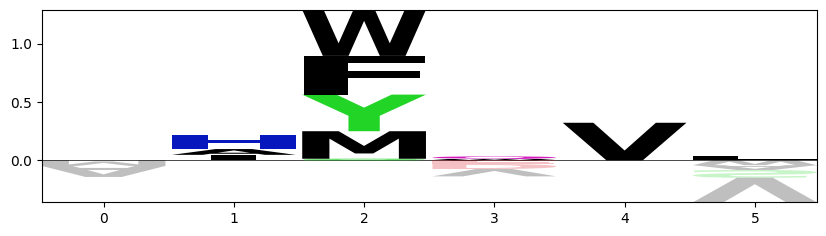

In [38]:
pega.plot(topn=10)

<Axes: xlabel='level_0', ylabel='0'>

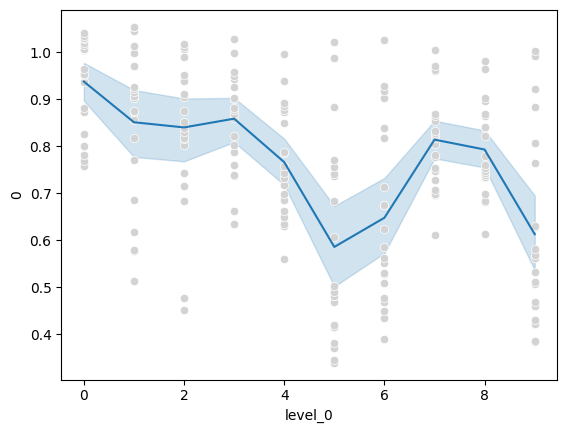

In [39]:
import pandas as pd
import seaborn as sns

sns.lineplot(pd.DataFrame(pega.fitness).T.stack().reset_index(), x="level_0", y=0)
sns.scatterplot(
    pd.DataFrame(pega.fitness).T.stack().reset_index(),
    x="level_0",
    y=0,
    color="lightgray",
)

<Axes: >

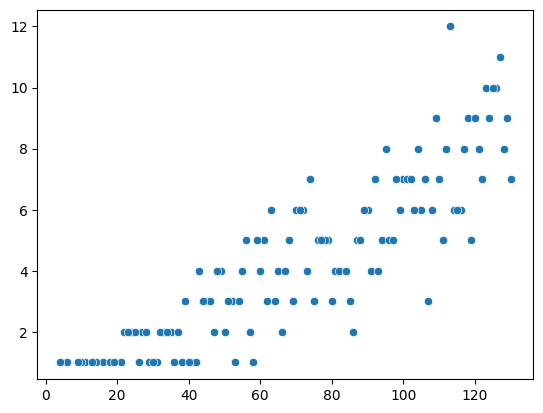

In [40]:
id_len = [(x.id, len(x.rules)) for x in pega.all_results.keys()]
sns.scatterplot(x=[x[0] for x in id_len], y=[x[1] for x in id_len])